<a href="https://colab.research.google.com/github/nitinmalviya326/deep-learning-lab/blob/main/Cats_vs_Dogs_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install torch torchvision kaggle matplotlib seaborn scikit-learn tqdm -q

# Import libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import shutil
from google.colab import drive, files
import warnings
warnings.filterwarnings('ignore')

# Set seeds
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Create directories
os.makedirs('/content/drive/MyDrive/DL_Lab/Experiment4', exist_ok=True)
os.makedirs('/content/models', exist_ok=True)
os.makedirs('/content/results', exist_ok=True)

print("Directories created successfully!")

Mounted at /content/drive
Directories created successfully!


In [3]:
# Upload kaggle.json
print("Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and extract dataset
print("\nDownloading dataset...")
!kaggle competitions download -c dogs-vs-cats
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip -d /content/data

print("Dataset downloaded successfully!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

 99% 808M/812M [00:11<00:00, 195MB/s]
100% 812M/812M [00:11<00:00, 73.5MB/s]
Dataset downloaded successfully!


In [4]:
# Create directory structure
base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

for directory in [train_dir, val_dir]:
    for category in ['cat', 'dog']:
        os.makedirs(os.path.join(directory, category), exist_ok=True)

# Get all images
source_dir = '/content/data/train'
all_images = os.listdir(source_dir)
cat_images = [img for img in all_images if img.startswith('cat.')]
dog_images = [img for img in all_images if img.startswith('dog.')]

print(f"Total cat images: {len(cat_images)}")
print(f"Total dog images: {len(dog_images)}")

# 80-20 train-val split
train_split = 0.8
n_train_cats = int(len(cat_images) * train_split)
n_train_dogs = int(len(dog_images) * train_split)

# Copy cat images
for i, img in enumerate(tqdm(cat_images, desc='Copying cat images')):
    src = os.path.join(source_dir, img)
    dst = os.path.join(train_dir if i < n_train_cats else val_dir, 'cat', img)
    shutil.copy(src, dst)

# Copy dog images
for i, img in enumerate(tqdm(dog_images, desc='Copying dog images')):
    src = os.path.join(source_dir, img)
    dst = os.path.join(train_dir if i < n_train_dogs else val_dir, 'dog', img)
    shutil.copy(src, dst)

print(f"\nDataset organized!")
print(f"Training images: {len(os.listdir(os.path.join(train_dir, 'cat'))) + len(os.listdir(os.path.join(train_dir, 'dog')))}")
print(f"Validation images: {len(os.listdir(os.path.join(val_dir, 'cat'))) + len(os.listdir(os.path.join(val_dir, 'dog')))}")

Total cat images: 12500
Total dog images: 12500


Copying dog images: 100%|██████████| 12500/12500 [00:01<00:00, 8523.66it/s]


Dataset organized!
Training images: 20000
Validation images: 5000


In [5]:
# Data transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and loaders
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")

Training samples: 20000
Validation samples: 5000
Classes: ['cat', 'dog']


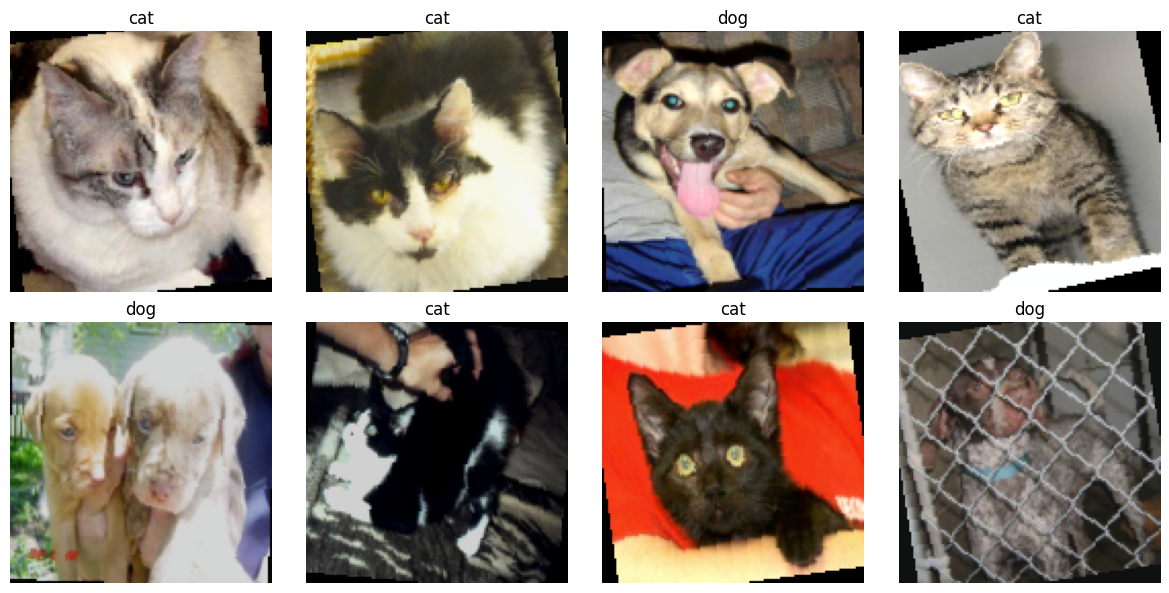

In [6]:
# Get sample batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < 8:
        img = images[i].numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(train_dataset.classes[labels[i]])
        ax.axis('off')
plt.tight_layout()
plt.savefig('/content/results/sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
class CatDogCNN(nn.Module):
    def __init__(self, activation='relu'):
        super(CatDogCNN, self).__init__()

        # Activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.2)

        # Conv layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)

        # FC layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool1(self.activation(self.bn1(self.conv1(x))))
        x = self.pool2(self.activation(self.bn2(self.conv2(x))))
        x = self.pool3(self.activation(self.bn3(self.conv3(x))))
        x = self.pool4(self.activation(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout1(self.activation(self.fc1(x)))
        x = self.dropout2(self.activation(self.fc2(x)))
        x = self.fc3(x)
        return x

# Test
model = CatDogCNN('relu').to(device)
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Total parameters: 8,910,338


In [8]:
def init_weights_xavier(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def init_weights_kaiming(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def init_weights_random(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.uniform_(m.weight, -0.1, 0.1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

print("Initialization functions defined!")

Initialization functions defined!


In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=60, device='cuda', model_name='model'):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': f'{running_loss/len(pbar):.4f}',
                            'acc': f'{100.*correct/total:.2f}%'})

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, f'/content/models/{model_name}_best.pth')

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

print("Training function ready!")

Training function ready!


In [10]:
def plot_history(history, title, save_path):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history['train_losses'], label='Train', linewidth=2)
    axes[0].plot(history['val_losses'], label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{title} - Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history['train_accs'], label='Train', linewidth=2)
    axes[1].plot(history['val_accs'], label='Val', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{title} - Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

print("Plotting function ready!")

Plotting function ready!


Starting 27 experiments...

Experiment 1/27: relu_xavier_sgd



Epoch 1/3: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s, loss=0.7645, acc=56.06%]


Epoch [1/3]
Train Loss: 0.7645, Train Acc: 56.06%
Val Loss: 0.6431, Val Acc: 62.60%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:06<00:00,  4.69it/s, loss=0.6278, acc=64.36%]


Epoch [2/3]
Train Loss: 0.6278, Train Acc: 64.36%
Val Loss: 0.5995, Val Acc: 70.36%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:08<00:00,  4.56it/s, loss=0.5932, acc=67.83%]


Epoch [3/3]
Train Loss: 0.5932, Train Acc: 67.83%
Val Loss: 0.5572, Val Acc: 73.66%
------------------------------------------------------------


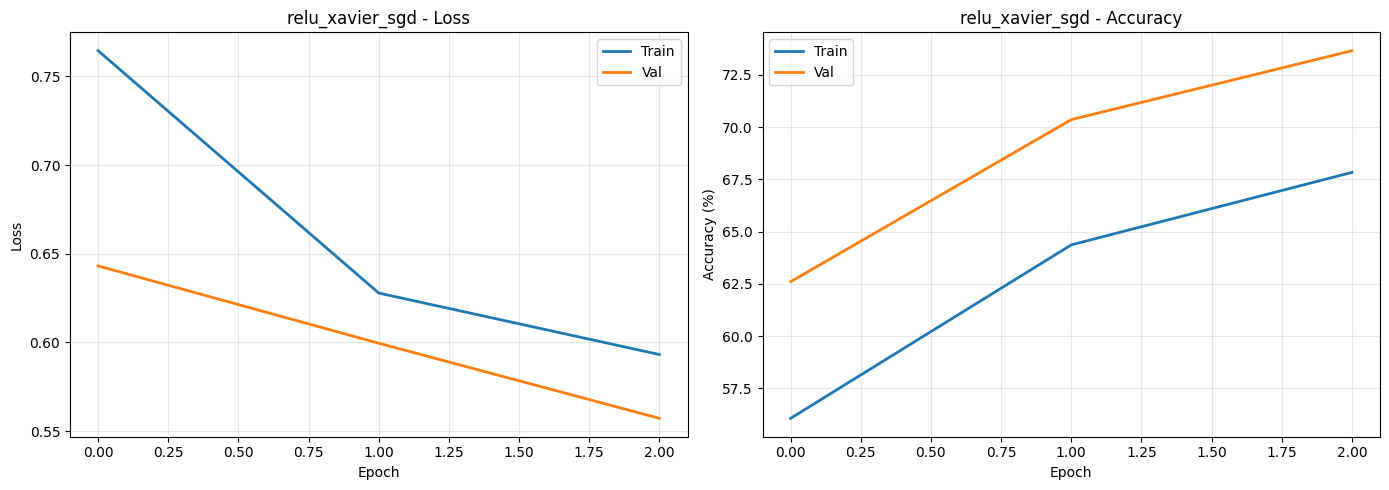

Best Val Acc: 73.66%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 2/27: relu_xavier_adam



Epoch 1/3: 100%|██████████| 313/313 [01:08<00:00,  4.58it/s, loss=1.2947, acc=54.37%]


Epoch [1/3]
Train Loss: 1.2947, Train Acc: 54.37%
Val Loss: 0.6424, Val Acc: 62.60%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:08<00:00,  4.54it/s, loss=0.6778, acc=54.66%]


Epoch [2/3]
Train Loss: 0.6778, Train Acc: 54.66%
Val Loss: 0.6474, Val Acc: 62.48%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:08<00:00,  4.54it/s, loss=0.6650, acc=57.45%]


Epoch [3/3]
Train Loss: 0.6650, Train Acc: 57.45%
Val Loss: 0.6567, Val Acc: 63.28%
------------------------------------------------------------


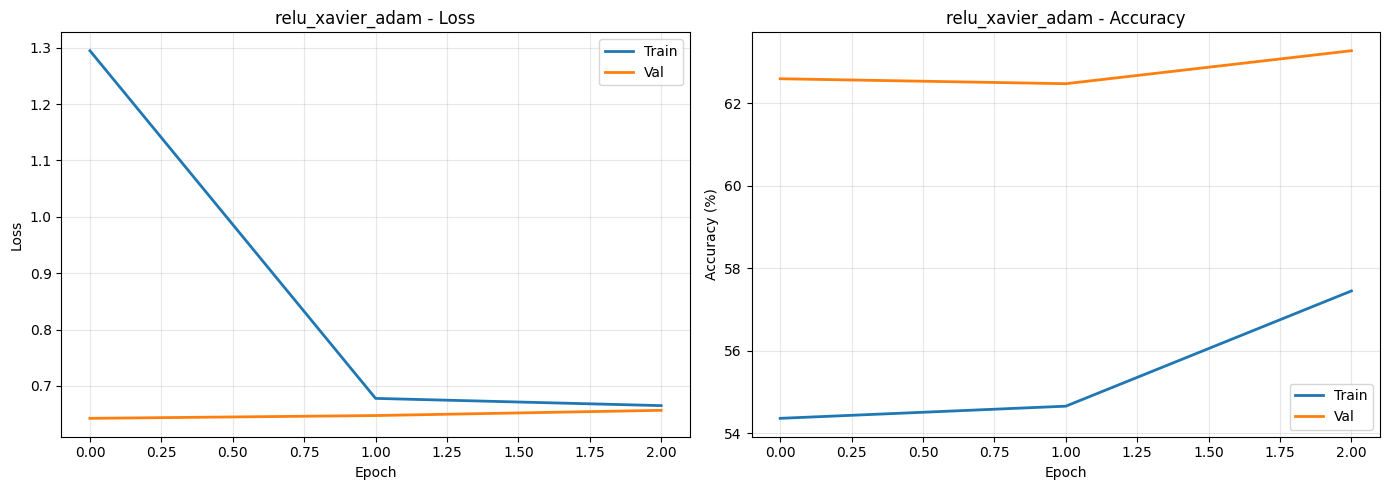

Best Val Acc: 63.28%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 3/27: relu_xavier_rmsprop



Epoch 1/3: 100%|██████████| 313/313 [01:08<00:00,  4.57it/s, loss=4.5577, acc=51.90%]


Epoch [1/3]
Train Loss: 4.5577, Train Acc: 51.90%
Val Loss: 0.6819, Val Acc: 54.48%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:09<00:00,  4.52it/s, loss=0.6881, acc=54.19%]


Epoch [2/3]
Train Loss: 0.6881, Train Acc: 54.19%
Val Loss: 0.6742, Val Acc: 55.76%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:06<00:00,  4.68it/s, loss=0.6980, acc=53.40%]


Epoch [3/3]
Train Loss: 0.6980, Train Acc: 53.40%
Val Loss: 0.6936, Val Acc: 50.02%
------------------------------------------------------------


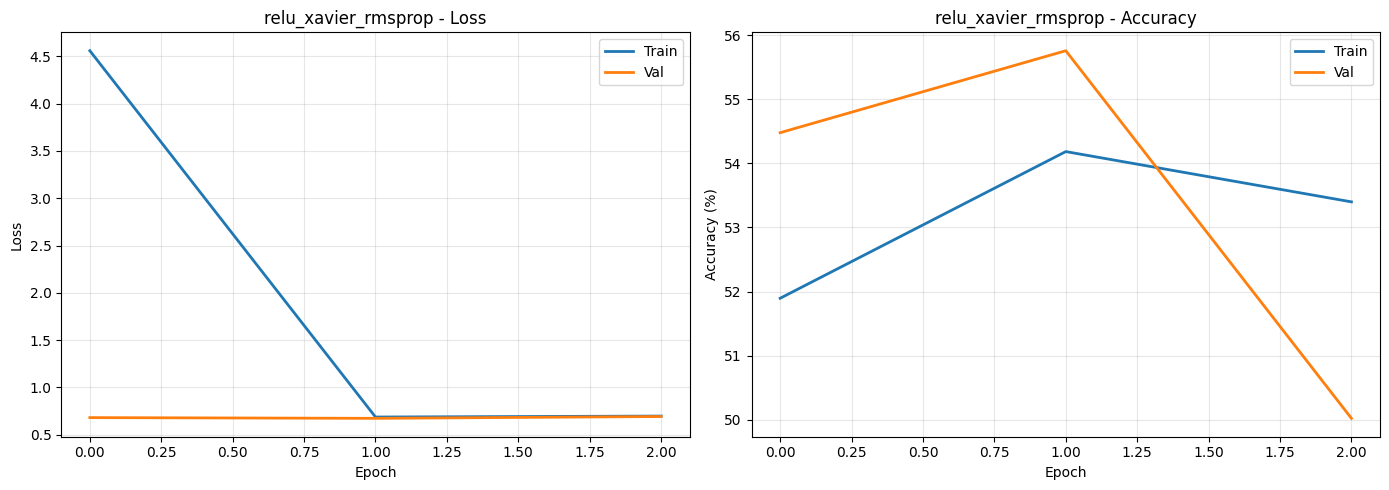

Best Val Acc: 55.76%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 4/27: relu_kaiming_sgd



Epoch 1/3: 100%|██████████| 313/313 [01:08<00:00,  4.54it/s, loss=0.8093, acc=55.93%]


Epoch [1/3]
Train Loss: 0.8093, Train Acc: 55.93%
Val Loss: 0.6210, Val Acc: 67.24%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:08<00:00,  4.57it/s, loss=0.6304, acc=62.26%]


Epoch [2/3]
Train Loss: 0.6304, Train Acc: 62.26%
Val Loss: 0.6018, Val Acc: 71.10%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:06<00:00,  4.69it/s, loss=0.6035, acc=65.57%]


Epoch [3/3]
Train Loss: 0.6035, Train Acc: 65.57%
Val Loss: 0.5719, Val Acc: 71.66%
------------------------------------------------------------


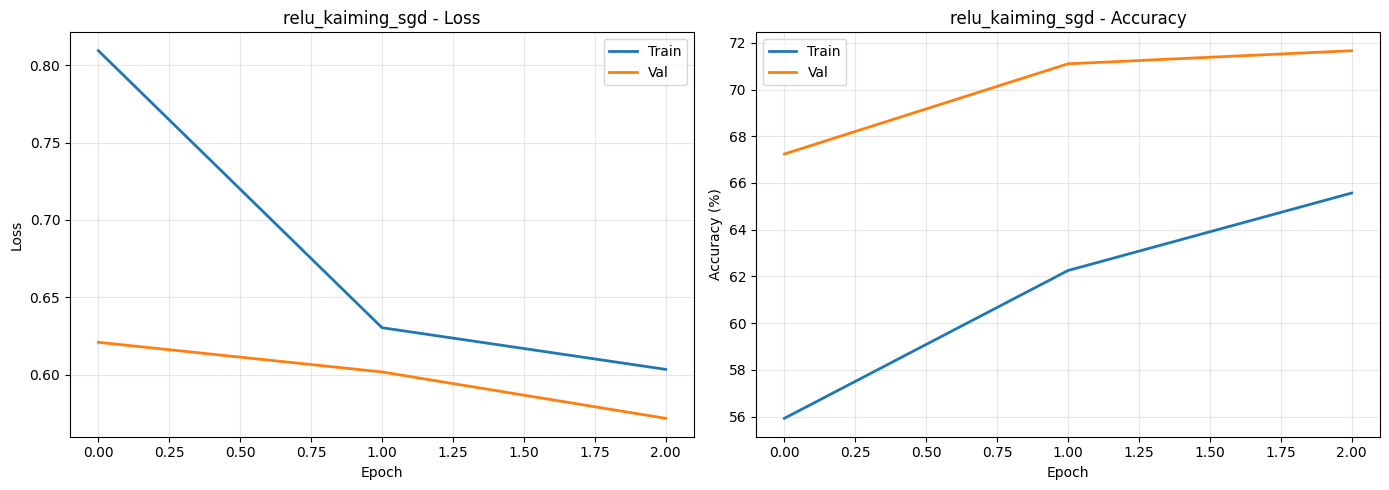

Best Val Acc: 71.66%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 5/27: relu_kaiming_adam



Epoch 1/3: 100%|██████████| 313/313 [01:08<00:00,  4.54it/s, loss=1.3728, acc=53.68%]


Epoch [1/3]
Train Loss: 1.3728, Train Acc: 53.68%
Val Loss: 0.6721, Val Acc: 56.68%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:09<00:00,  4.50it/s, loss=0.6785, acc=54.84%]


Epoch [2/3]
Train Loss: 0.6785, Train Acc: 54.84%
Val Loss: 0.6586, Val Acc: 58.22%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:08<00:00,  4.54it/s, loss=0.6707, acc=56.45%]


Epoch [3/3]
Train Loss: 0.6707, Train Acc: 56.45%
Val Loss: 0.6433, Val Acc: 61.02%
------------------------------------------------------------


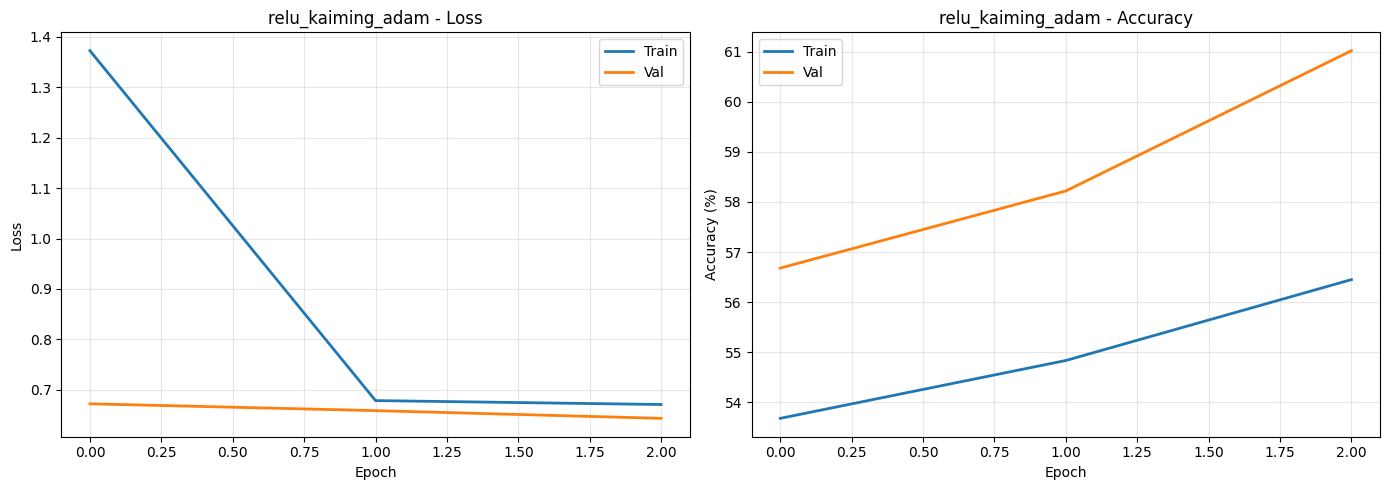

Best Val Acc: 61.02%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 6/27: relu_kaiming_rmsprop



Epoch 1/3: 100%|██████████| 313/313 [01:07<00:00,  4.63it/s, loss=5.4887, acc=50.49%]


Epoch [1/3]
Train Loss: 5.4887, Train Acc: 50.49%
Val Loss: 0.6935, Val Acc: 50.08%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:08<00:00,  4.56it/s, loss=0.6945, acc=49.10%]


Epoch [2/3]
Train Loss: 0.6945, Train Acc: 49.10%
Val Loss: 0.6933, Val Acc: 49.98%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:08<00:00,  4.56it/s, loss=0.6947, acc=49.72%]


Epoch [3/3]
Train Loss: 0.6947, Train Acc: 49.72%
Val Loss: 0.6931, Val Acc: 50.00%
------------------------------------------------------------


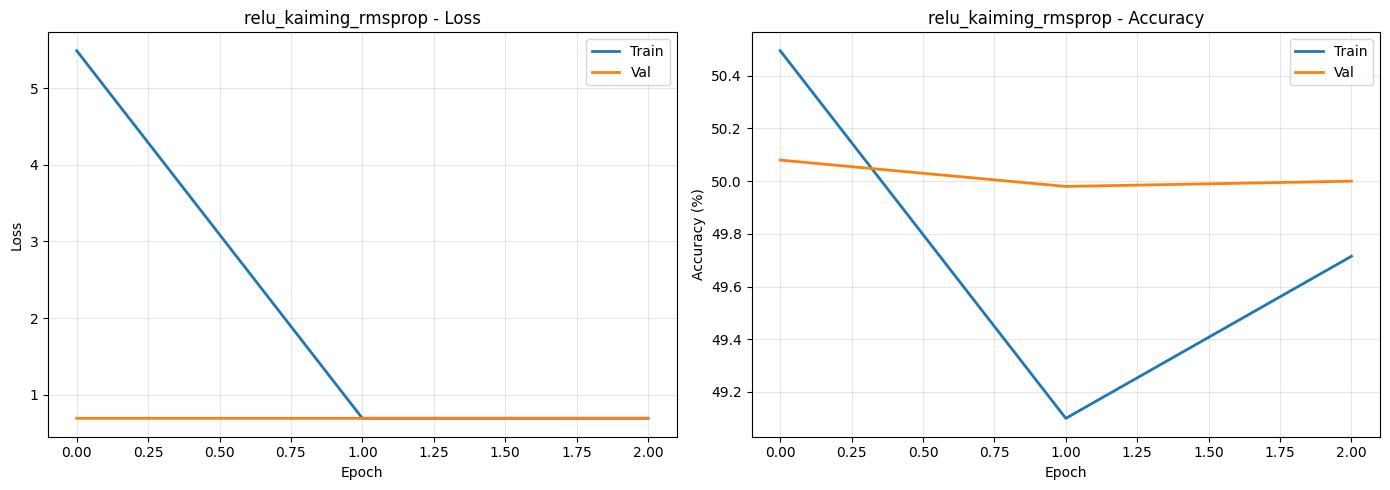

Best Val Acc: 50.08%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 7/27: relu_random_sgd



Epoch 1/3: 100%|██████████| 313/313 [01:08<00:00,  4.54it/s, loss=0.8907, acc=50.80%]


Epoch [1/3]
Train Loss: 0.8907, Train Acc: 50.80%
Val Loss: 0.6931, Val Acc: 50.00%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:09<00:00,  4.52it/s, loss=0.6938, acc=51.73%]


Epoch [2/3]
Train Loss: 0.6938, Train Acc: 51.73%
Val Loss: 0.6932, Val Acc: 44.42%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:08<00:00,  4.54it/s, loss=0.6934, acc=52.09%]


Epoch [3/3]
Train Loss: 0.6934, Train Acc: 52.09%
Val Loss: 0.6927, Val Acc: 50.92%
------------------------------------------------------------


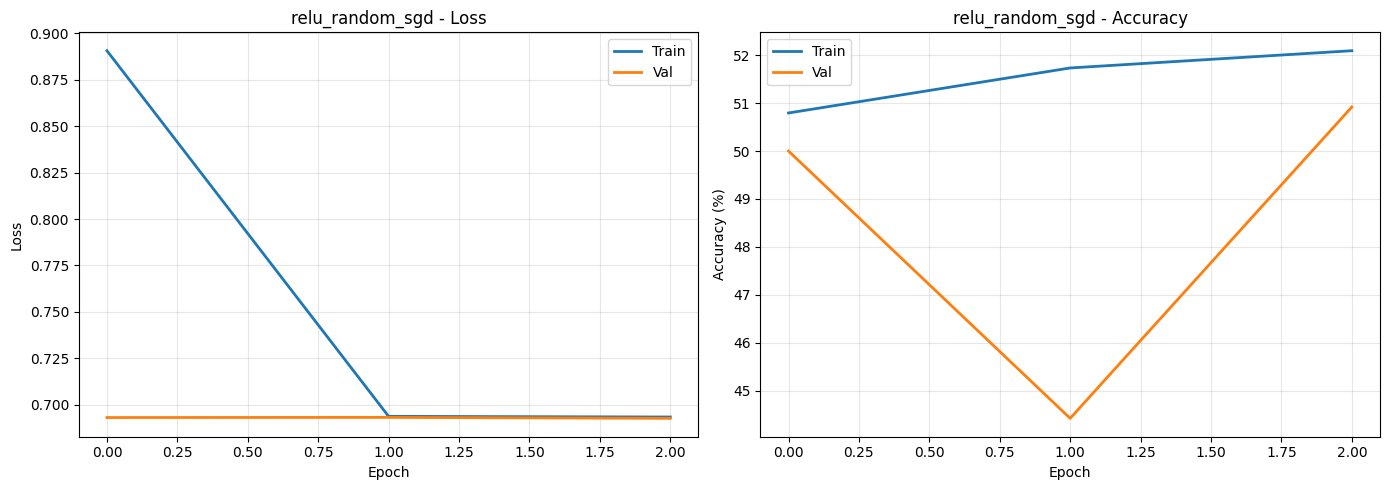

Best Val Acc: 50.92%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 8/27: relu_random_adam



Epoch 1/3: 100%|██████████| 313/313 [01:09<00:00,  4.48it/s, loss=1.1685, acc=56.05%]


Epoch [1/3]
Train Loss: 1.1685, Train Acc: 56.05%
Val Loss: 0.6381, Val Acc: 60.18%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:08<00:00,  4.57it/s, loss=0.6502, acc=61.55%]


Epoch [2/3]
Train Loss: 0.6502, Train Acc: 61.55%
Val Loss: 0.6034, Val Acc: 67.66%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:09<00:00,  4.50it/s, loss=0.6260, acc=63.75%]


Epoch [3/3]
Train Loss: 0.6260, Train Acc: 63.75%
Val Loss: 0.5684, Val Acc: 70.82%
------------------------------------------------------------


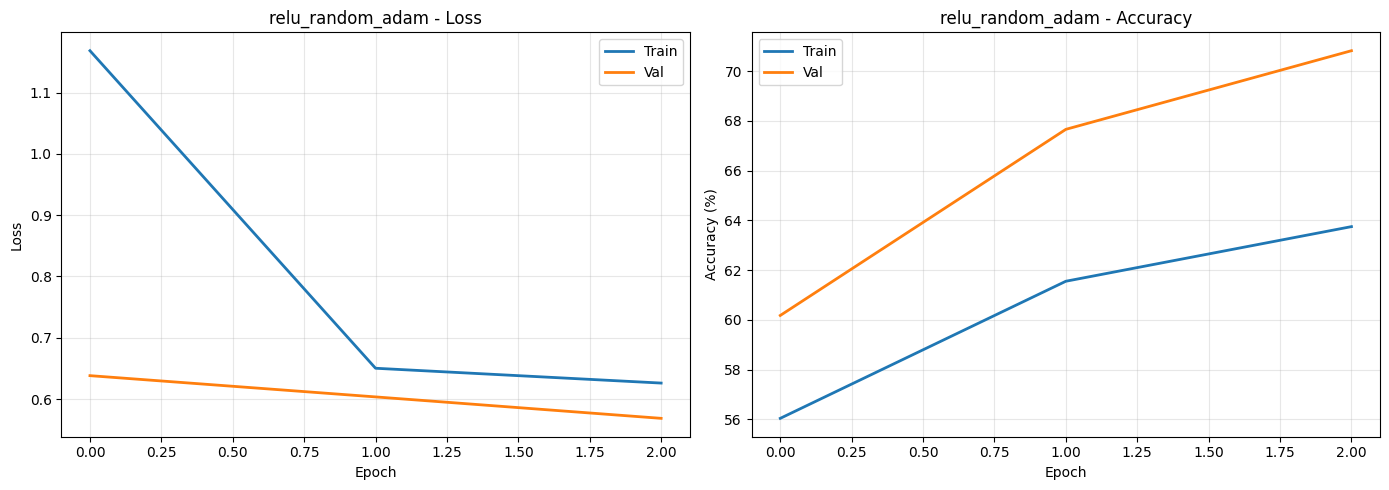

Best Val Acc: 70.82%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 9/27: relu_random_rmsprop



Epoch 1/3: 100%|██████████| 313/313 [01:09<00:00,  4.49it/s, loss=3.6832, acc=52.28%]


Epoch [1/3]
Train Loss: 3.6832, Train Acc: 52.28%
Val Loss: 0.6962, Val Acc: 51.00%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s, loss=0.7180, acc=57.18%]


Epoch [2/3]
Train Loss: 0.7180, Train Acc: 57.18%
Val Loss: 0.6284, Val Acc: 63.92%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:09<00:00,  4.52it/s, loss=0.6321, acc=65.40%]


Epoch [3/3]
Train Loss: 0.6321, Train Acc: 65.40%
Val Loss: 0.6039, Val Acc: 66.30%
------------------------------------------------------------


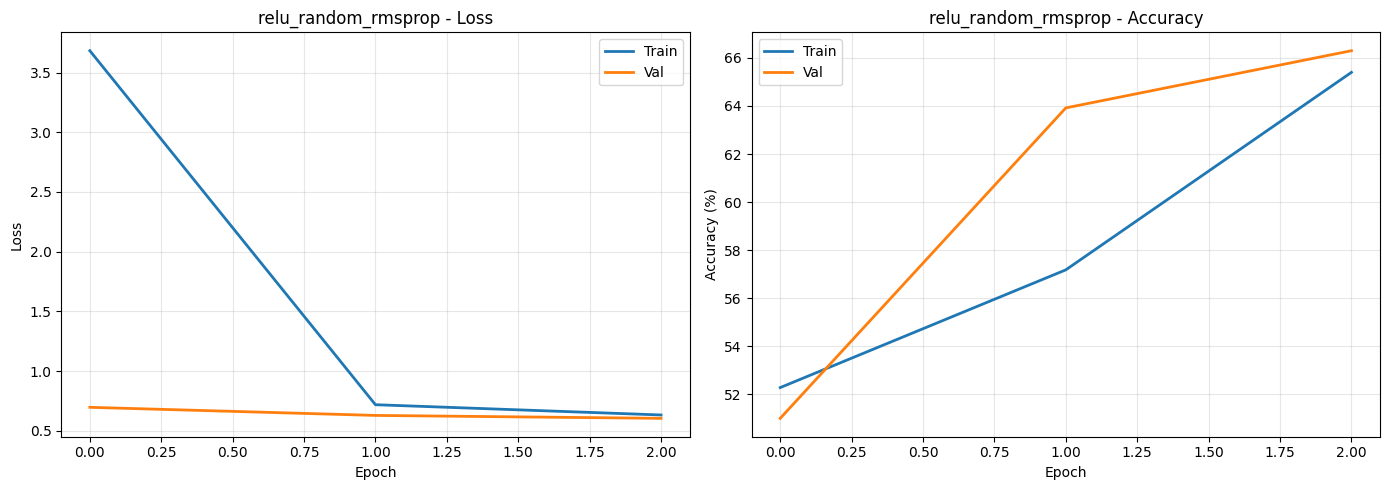

Best Val Acc: 66.30%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 10/27: tanh_xavier_sgd



Epoch 1/3: 100%|██████████| 313/313 [01:10<00:00,  4.44it/s, loss=0.7030, acc=58.99%]


Epoch [1/3]
Train Loss: 0.7030, Train Acc: 58.99%
Val Loss: 0.5903, Val Acc: 67.56%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s, loss=0.6274, acc=65.32%]


Epoch [2/3]
Train Loss: 0.6274, Train Acc: 65.32%
Val Loss: 0.6055, Val Acc: 66.40%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:10<00:00,  4.43it/s, loss=0.6018, acc=68.13%]


Epoch [3/3]
Train Loss: 0.6018, Train Acc: 68.13%
Val Loss: 0.5709, Val Acc: 71.62%
------------------------------------------------------------


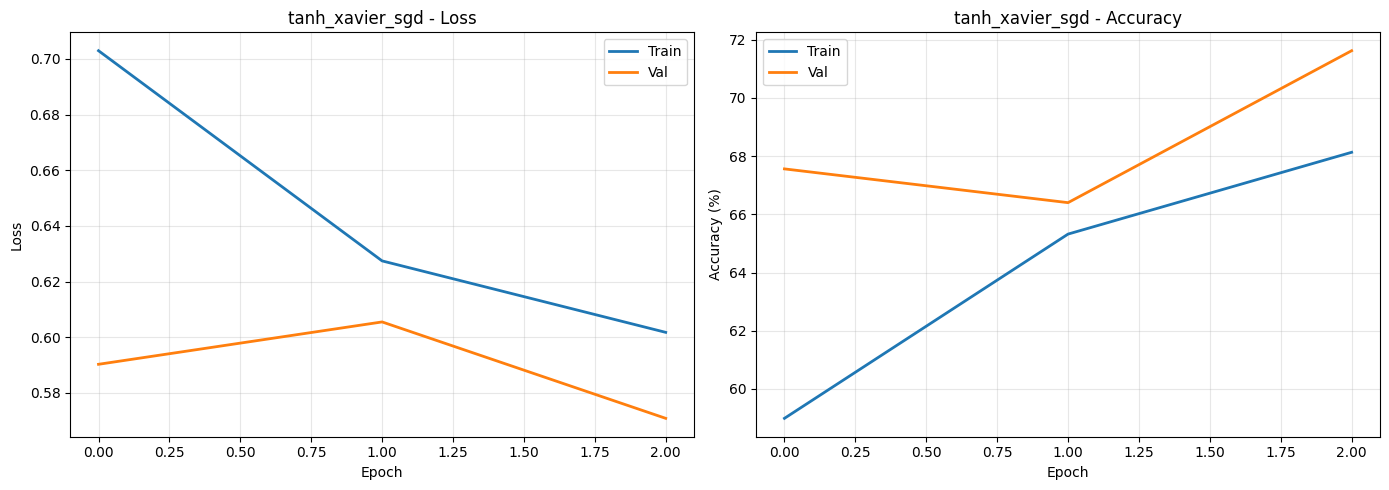

Best Val Acc: 71.62%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 11/27: tanh_xavier_adam



Epoch 1/3: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s, loss=0.8464, acc=53.98%]


Epoch [1/3]
Train Loss: 0.8464, Train Acc: 53.98%
Val Loss: 0.6618, Val Acc: 59.82%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:10<00:00,  4.46it/s, loss=0.6846, acc=58.38%]


Epoch [2/3]
Train Loss: 0.6846, Train Acc: 58.38%
Val Loss: 0.6200, Val Acc: 64.02%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:11<00:00,  4.36it/s, loss=0.6356, acc=63.04%]


Epoch [3/3]
Train Loss: 0.6356, Train Acc: 63.04%
Val Loss: 0.5989, Val Acc: 66.34%
------------------------------------------------------------


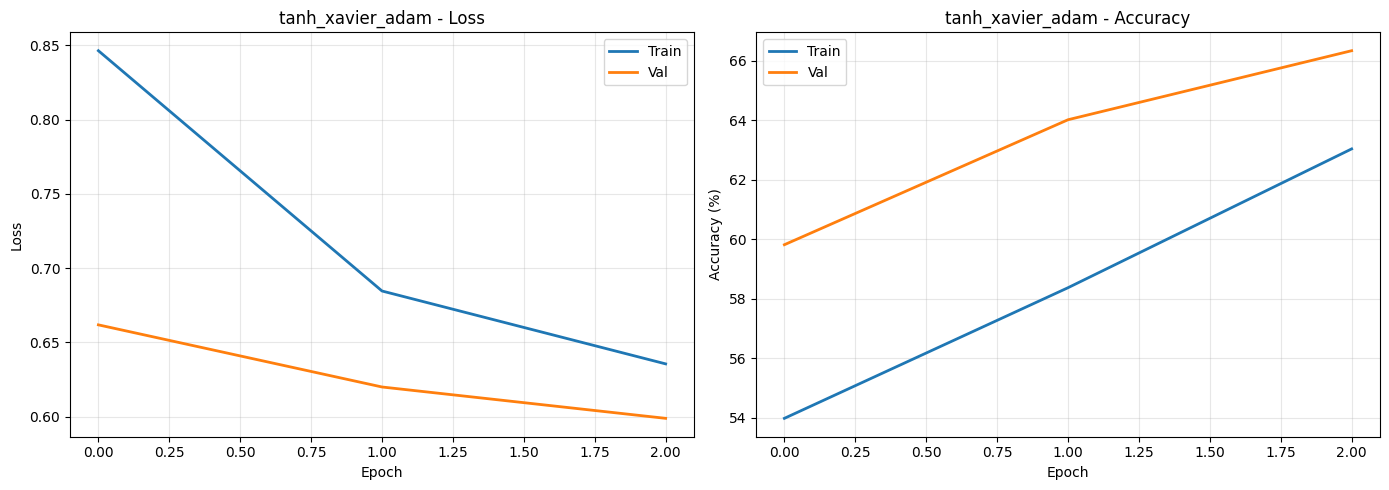

Best Val Acc: 66.34%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 12/27: tanh_xavier_rmsprop



Epoch 1/3: 100%|██████████| 313/313 [01:11<00:00,  4.37it/s, loss=0.8278, acc=50.59%]


Epoch [1/3]
Train Loss: 0.8278, Train Acc: 50.59%
Val Loss: 0.6928, Val Acc: 54.54%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s, loss=0.7079, acc=53.37%]


Epoch [2/3]
Train Loss: 0.7079, Train Acc: 53.37%
Val Loss: 0.6722, Val Acc: 58.02%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s, loss=0.6671, acc=58.98%]


Epoch [3/3]
Train Loss: 0.6671, Train Acc: 58.98%
Val Loss: 0.6577, Val Acc: 58.98%
------------------------------------------------------------


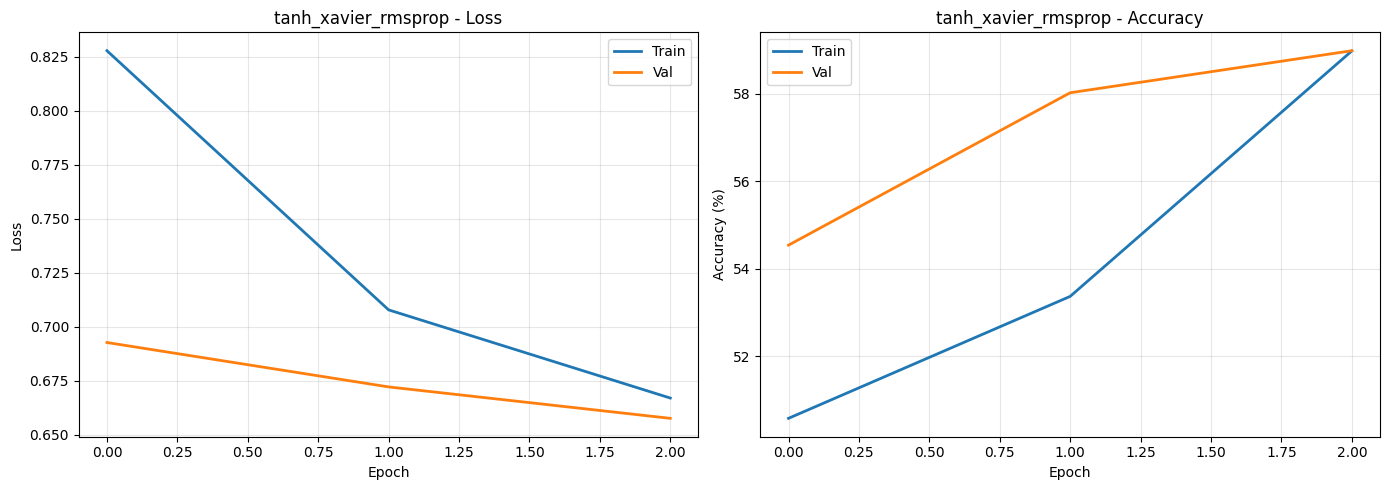

Best Val Acc: 58.98%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 13/27: tanh_kaiming_sgd



Epoch 1/3: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s, loss=0.6853, acc=61.23%]


Epoch [1/3]
Train Loss: 0.6853, Train Acc: 61.23%
Val Loss: 0.6003, Val Acc: 66.26%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s, loss=0.6097, acc=66.91%]


Epoch [2/3]
Train Loss: 0.6097, Train Acc: 66.91%
Val Loss: 0.5669, Val Acc: 71.10%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s, loss=0.5882, acc=69.62%]


Epoch [3/3]
Train Loss: 0.5882, Train Acc: 69.62%
Val Loss: 0.6514, Val Acc: 67.70%
------------------------------------------------------------


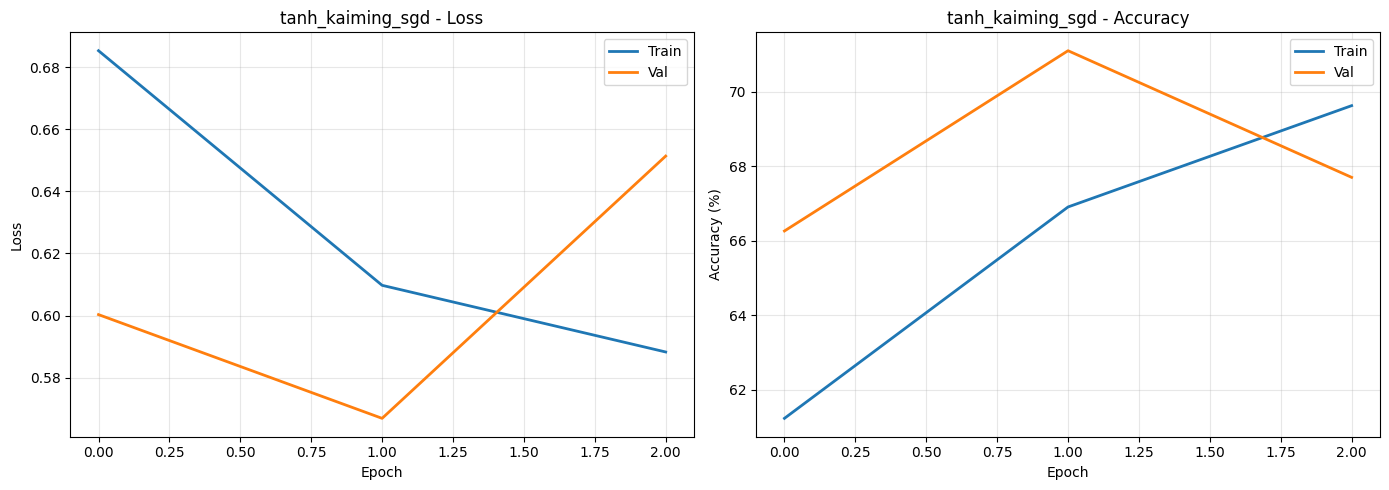

Best Val Acc: 71.10%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 14/27: tanh_kaiming_adam



Epoch 1/3: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s, loss=0.8072, acc=54.66%]


Epoch [1/3]
Train Loss: 0.8072, Train Acc: 54.66%
Val Loss: 0.7012, Val Acc: 57.24%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:12<00:00,  4.33it/s, loss=0.6816, acc=58.88%]


Epoch [2/3]
Train Loss: 0.6816, Train Acc: 58.88%
Val Loss: 0.6227, Val Acc: 63.66%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s, loss=0.6460, acc=61.87%]


Epoch [3/3]
Train Loss: 0.6460, Train Acc: 61.87%
Val Loss: 0.6146, Val Acc: 65.46%
------------------------------------------------------------


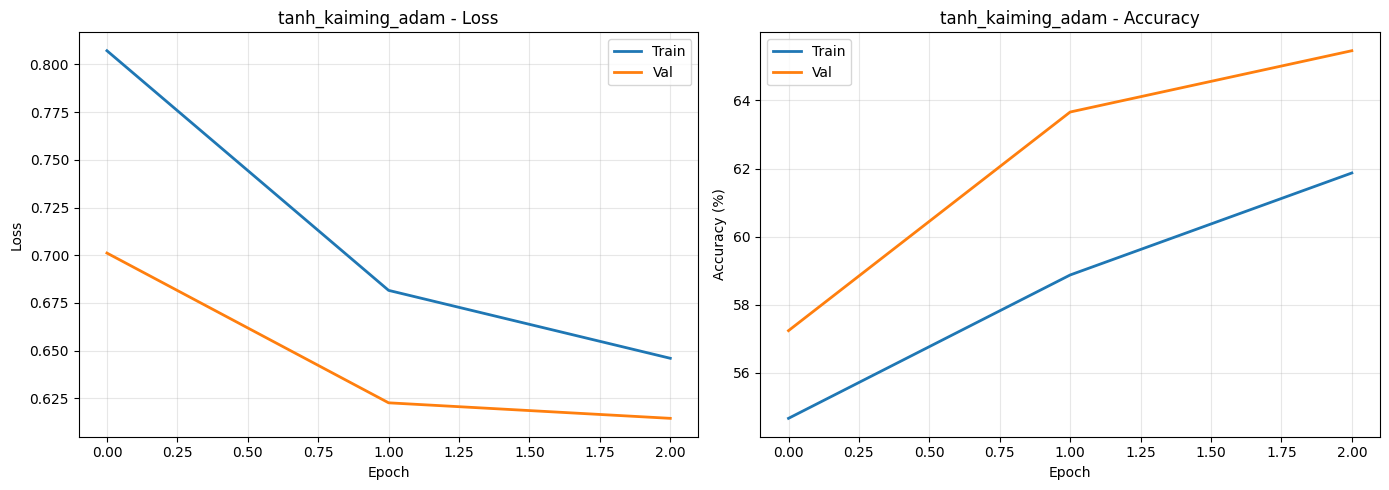

Best Val Acc: 65.46%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 15/27: tanh_kaiming_rmsprop



Epoch 1/3: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s, loss=0.8167, acc=54.32%]


Epoch [1/3]
Train Loss: 0.8167, Train Acc: 54.32%
Val Loss: 0.7577, Val Acc: 50.82%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:13<00:00,  4.28it/s, loss=0.6713, acc=59.43%]


Epoch [2/3]
Train Loss: 0.6713, Train Acc: 59.43%
Val Loss: 0.6510, Val Acc: 61.00%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:12<00:00,  4.30it/s, loss=0.6326, acc=63.66%]


Epoch [3/3]
Train Loss: 0.6326, Train Acc: 63.66%
Val Loss: 0.6328, Val Acc: 62.36%
------------------------------------------------------------


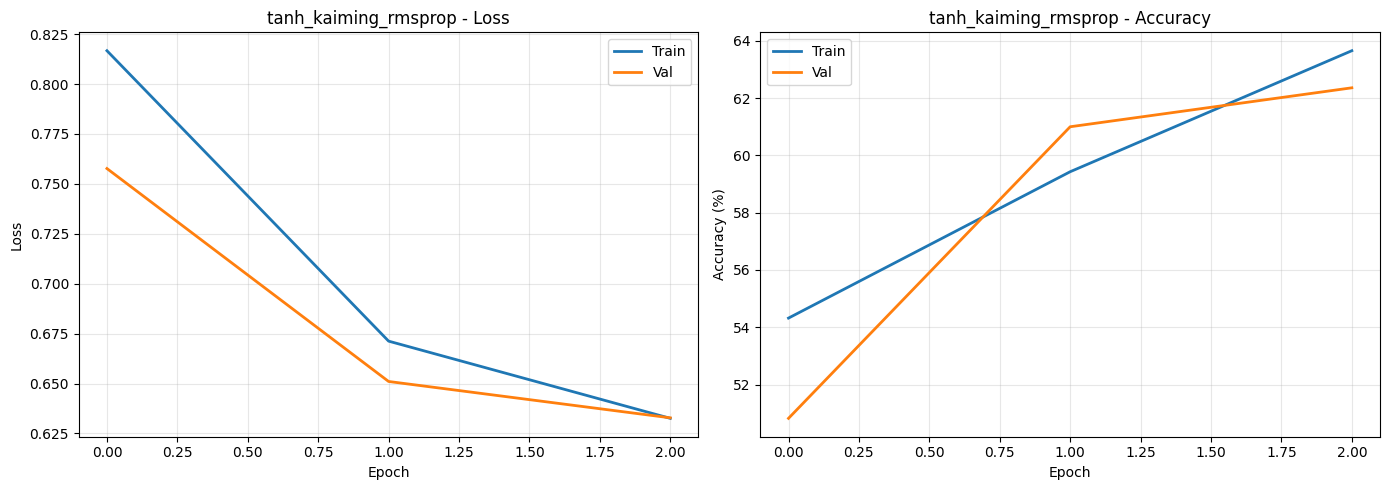

Best Val Acc: 62.36%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 16/27: tanh_random_sgd



Epoch 1/3: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s, loss=0.7160, acc=55.70%]


Epoch [1/3]
Train Loss: 0.7160, Train Acc: 55.70%
Val Loss: 0.6912, Val Acc: 58.84%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:13<00:00,  4.27it/s, loss=0.6780, acc=60.13%]


Epoch [2/3]
Train Loss: 0.6780, Train Acc: 60.13%
Val Loss: 0.6447, Val Acc: 64.28%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:13<00:00,  4.24it/s, loss=0.6629, acc=62.70%]


Epoch [3/3]
Train Loss: 0.6629, Train Acc: 62.70%
Val Loss: 0.5961, Val Acc: 68.30%
------------------------------------------------------------


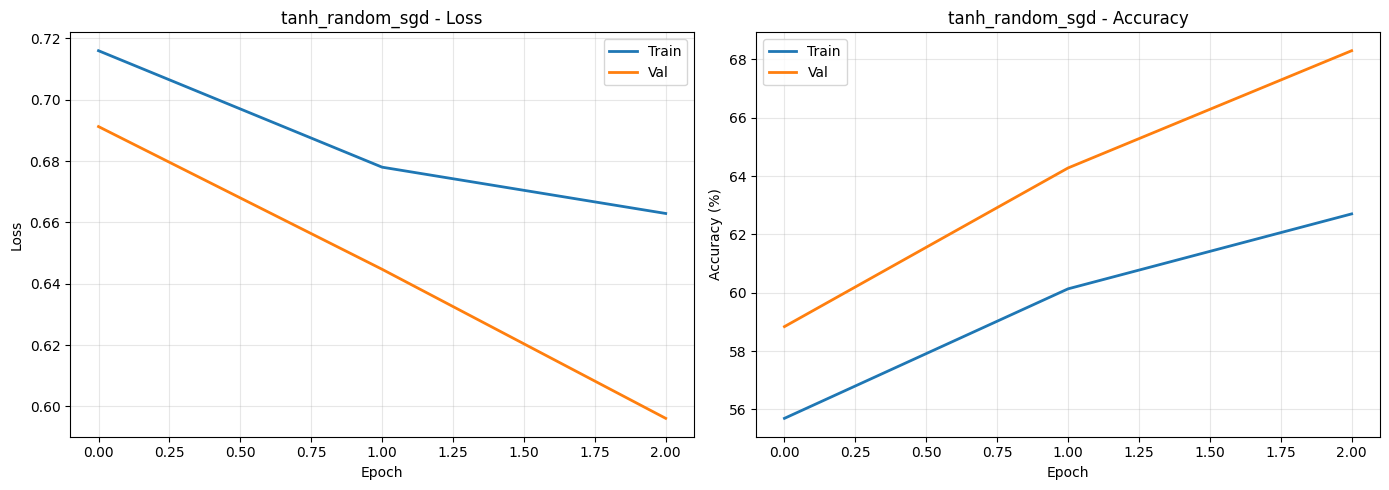

Best Val Acc: 68.30%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 17/27: tanh_random_adam



Epoch 1/3: 100%|██████████| 313/313 [01:13<00:00,  4.23it/s, loss=0.7089, acc=56.81%]


Epoch [1/3]
Train Loss: 0.7089, Train Acc: 56.81%
Val Loss: 0.6358, Val Acc: 62.36%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:12<00:00,  4.31it/s, loss=0.6430, acc=62.27%]


Epoch [2/3]
Train Loss: 0.6430, Train Acc: 62.27%
Val Loss: 0.6221, Val Acc: 64.56%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:13<00:00,  4.24it/s, loss=0.6146, acc=65.62%]


Epoch [3/3]
Train Loss: 0.6146, Train Acc: 65.62%
Val Loss: 0.6107, Val Acc: 67.42%
------------------------------------------------------------


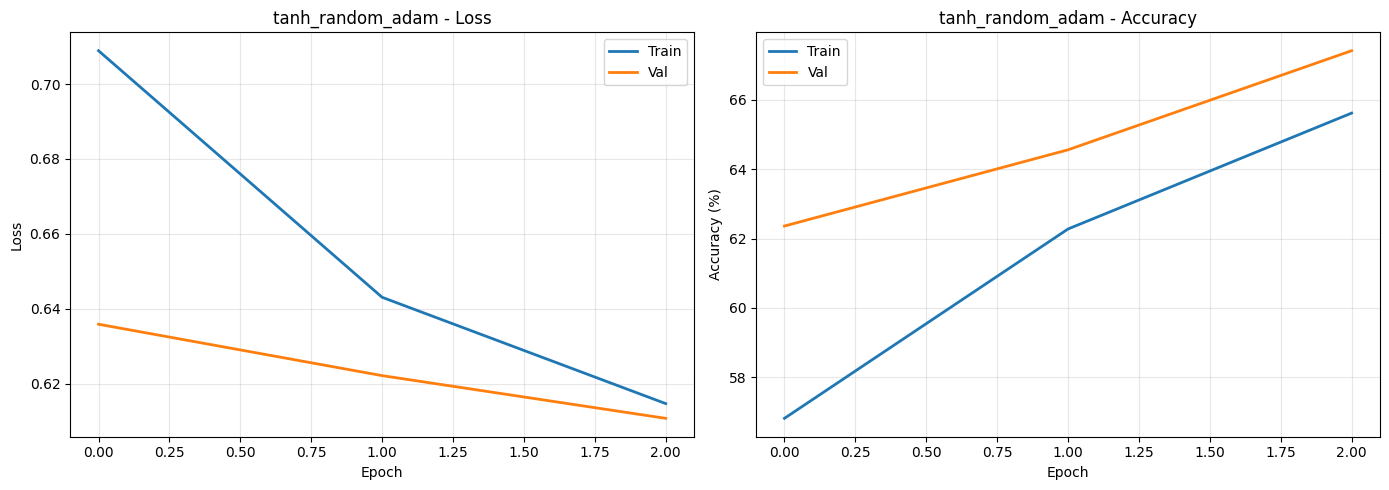

Best Val Acc: 67.42%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 18/27: tanh_random_rmsprop



Epoch 1/3: 100%|██████████| 313/313 [01:13<00:00,  4.25it/s, loss=0.7463, acc=53.54%]


Epoch [1/3]
Train Loss: 0.7463, Train Acc: 53.54%
Val Loss: 0.7010, Val Acc: 58.48%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:12<00:00,  4.32it/s, loss=0.6764, acc=57.48%]


Epoch [2/3]
Train Loss: 0.6764, Train Acc: 57.48%
Val Loss: 0.6559, Val Acc: 61.02%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:13<00:00,  4.27it/s, loss=0.6503, acc=61.30%]


Epoch [3/3]
Train Loss: 0.6503, Train Acc: 61.30%
Val Loss: 0.6606, Val Acc: 61.84%
------------------------------------------------------------


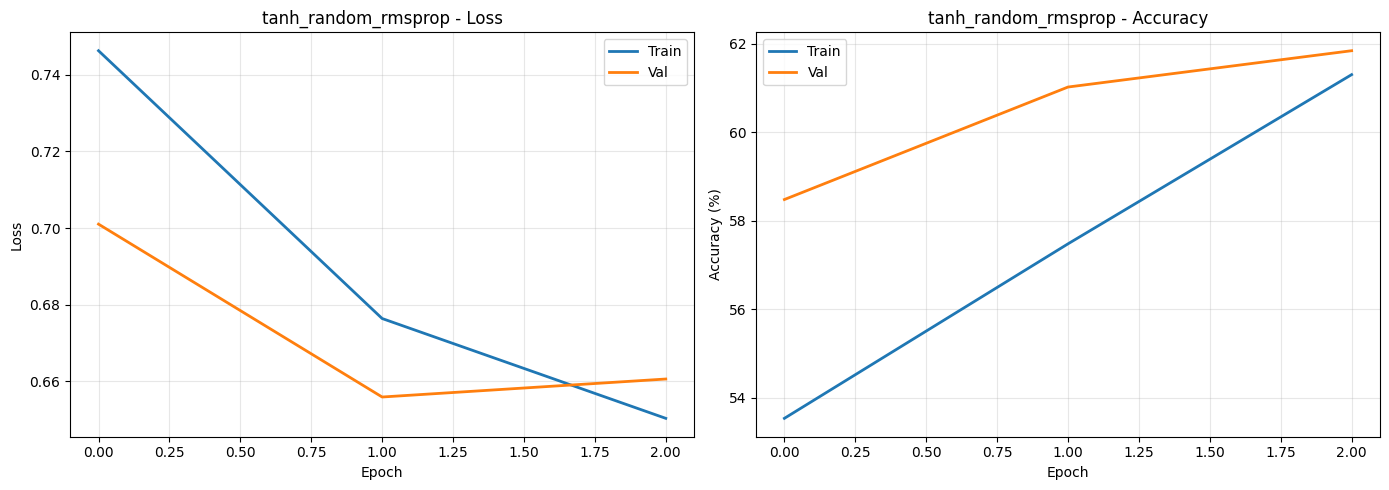

Best Val Acc: 61.84%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 19/27: leaky_relu_xavier_sgd



Epoch 1/3: 100%|██████████| 313/313 [01:13<00:00,  4.25it/s, loss=0.8468, acc=55.45%]


Epoch [1/3]
Train Loss: 0.8468, Train Acc: 55.45%
Val Loss: 0.6468, Val Acc: 60.52%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:13<00:00,  4.26it/s, loss=0.6516, acc=62.81%]


Epoch [2/3]
Train Loss: 0.6516, Train Acc: 62.81%
Val Loss: 0.6691, Val Acc: 55.92%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:13<00:00,  4.23it/s, loss=0.5938, acc=68.33%]


Epoch [3/3]
Train Loss: 0.5938, Train Acc: 68.33%
Val Loss: 0.5536, Val Acc: 72.88%
------------------------------------------------------------


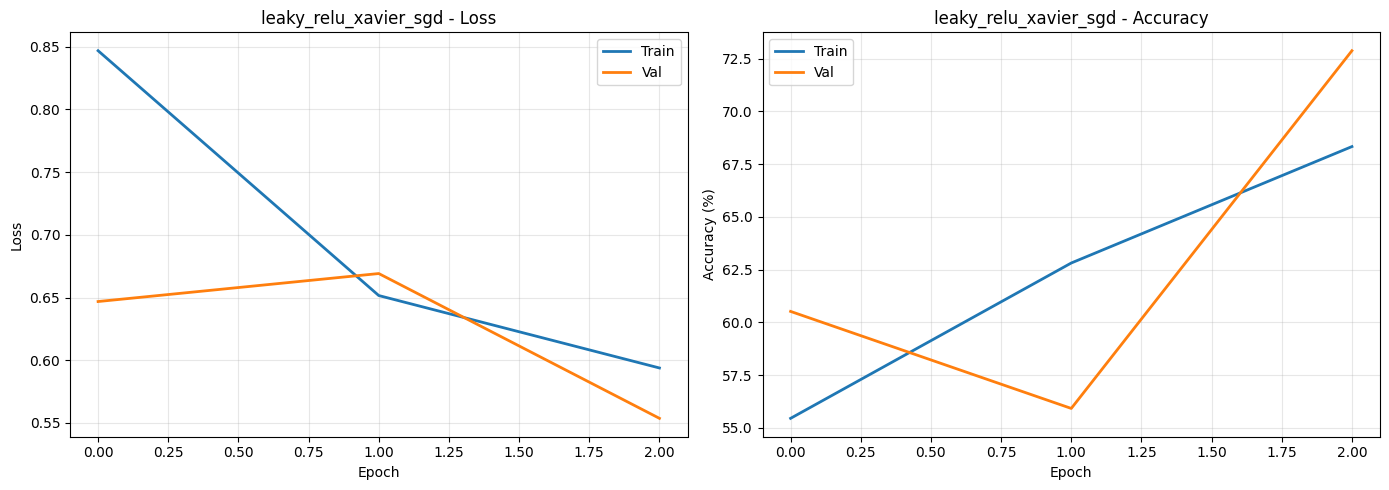

Best Val Acc: 72.88%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 20/27: leaky_relu_xavier_adam



Epoch 1/3: 100%|██████████| 313/313 [01:14<00:00,  4.23it/s, loss=1.5695, acc=55.77%]


Epoch [1/3]
Train Loss: 1.5695, Train Acc: 55.77%
Val Loss: 0.6726, Val Acc: 61.64%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:14<00:00,  4.23it/s, loss=0.7552, acc=62.55%]


Epoch [2/3]
Train Loss: 0.7552, Train Acc: 62.55%
Val Loss: 0.5920, Val Acc: 70.00%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:14<00:00,  4.19it/s, loss=0.6426, acc=67.26%]


Epoch [3/3]
Train Loss: 0.6426, Train Acc: 67.26%
Val Loss: 0.5775, Val Acc: 70.28%
------------------------------------------------------------


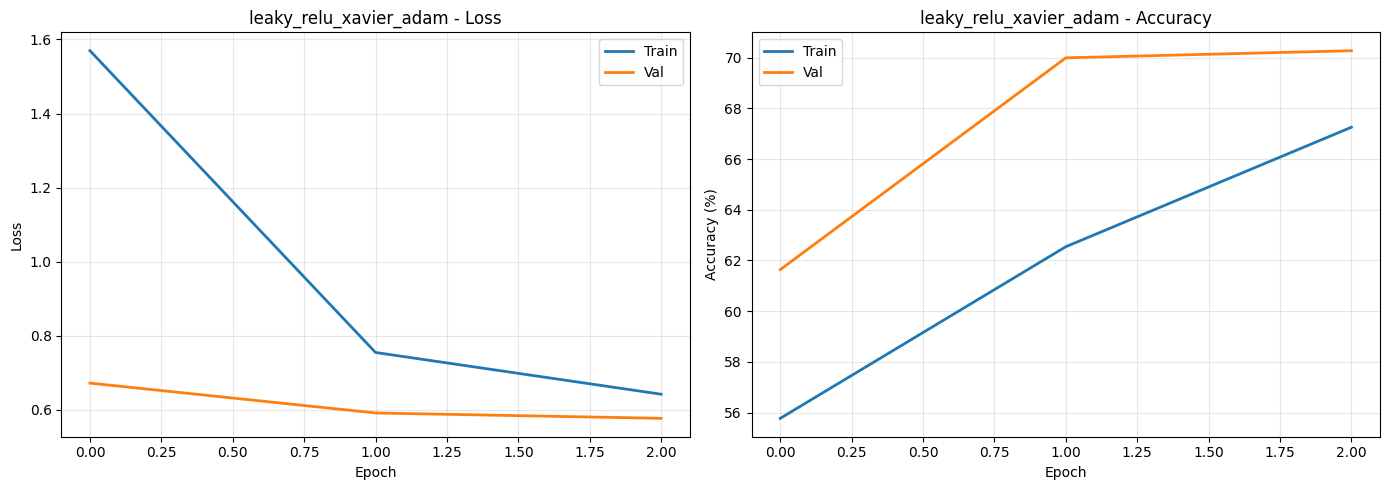

Best Val Acc: 70.28%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 21/27: leaky_relu_xavier_rmsprop



Epoch 1/3: 100%|██████████| 313/313 [01:13<00:00,  4.24it/s, loss=10.3522, acc=54.80%]


Epoch [1/3]
Train Loss: 10.3522, Train Acc: 54.80%
Val Loss: 1.3659, Val Acc: 51.52%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:16<00:00,  4.10it/s, loss=1.0773, acc=56.37%]


Epoch [2/3]
Train Loss: 1.0773, Train Acc: 56.37%
Val Loss: 1.0297, Val Acc: 51.94%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:15<00:00,  4.12it/s, loss=0.8345, acc=59.91%]


Epoch [3/3]
Train Loss: 0.8345, Train Acc: 59.91%
Val Loss: 0.6350, Val Acc: 67.98%
------------------------------------------------------------


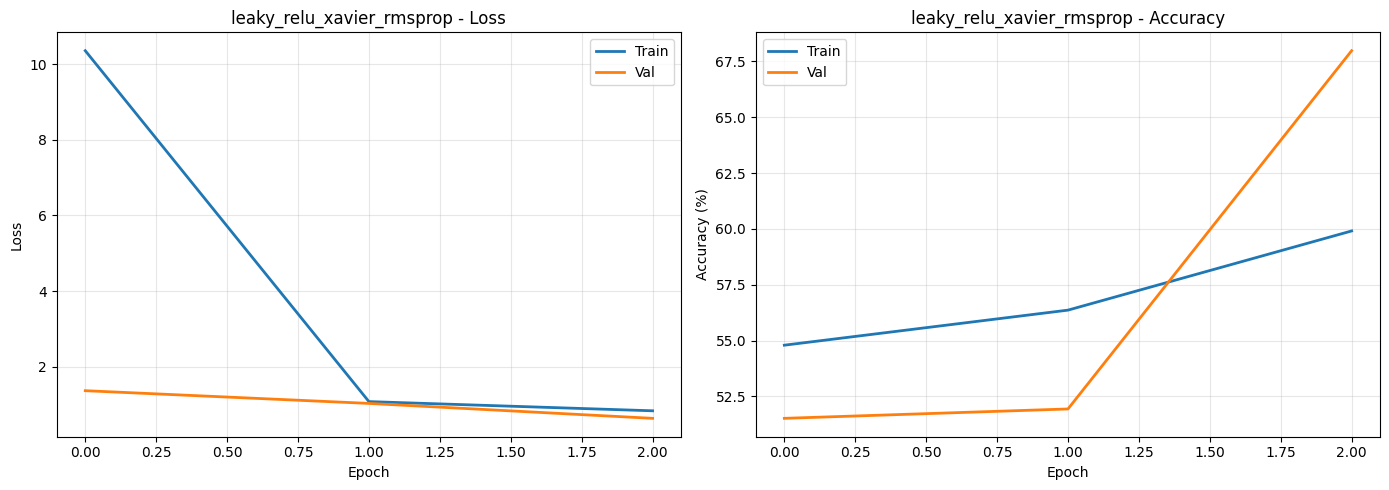

Best Val Acc: 67.98%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 22/27: leaky_relu_kaiming_sgd



Epoch 1/3: 100%|██████████| 313/313 [01:17<00:00,  4.04it/s, loss=1.3135, acc=52.83%]


Epoch [1/3]
Train Loss: 1.3135, Train Acc: 52.83%
Val Loss: 0.6648, Val Acc: 58.58%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:15<00:00,  4.17it/s, loss=0.7100, acc=57.83%]


Epoch [2/3]
Train Loss: 0.7100, Train Acc: 57.83%
Val Loss: 0.6642, Val Acc: 57.26%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s, loss=0.6442, acc=63.84%]


Epoch [3/3]
Train Loss: 0.6442, Train Acc: 63.84%
Val Loss: 0.5829, Val Acc: 69.14%
------------------------------------------------------------


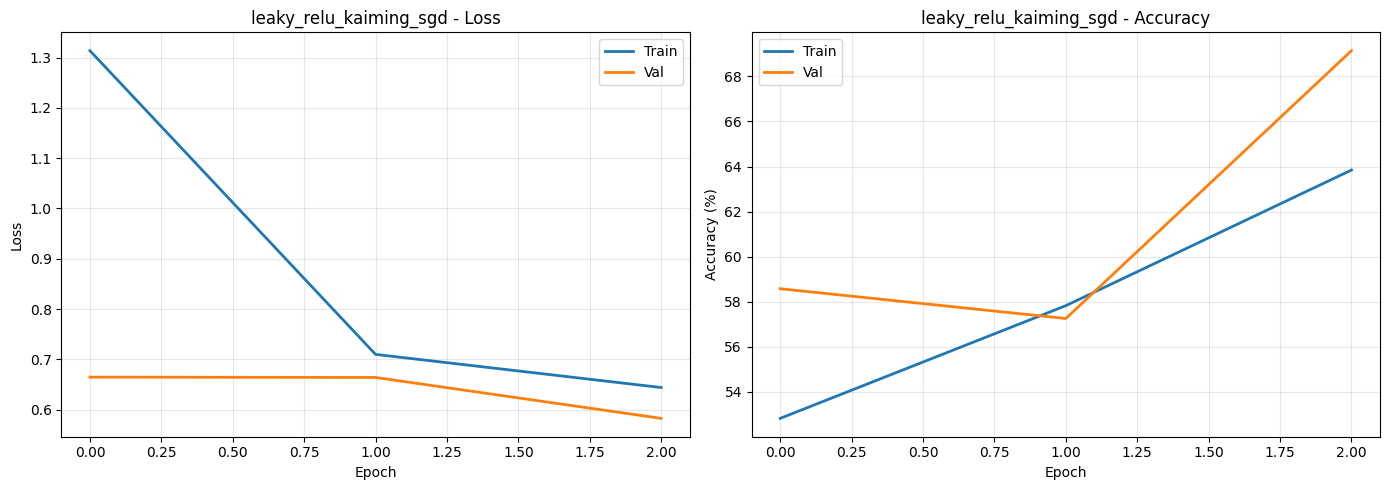

Best Val Acc: 69.14%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 23/27: leaky_relu_kaiming_adam



Epoch 1/3: 100%|██████████| 313/313 [01:15<00:00,  4.15it/s, loss=2.3692, acc=55.10%]


Epoch [1/3]
Train Loss: 2.3692, Train Acc: 55.10%
Val Loss: 0.6351, Val Acc: 69.16%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:15<00:00,  4.14it/s, loss=0.7947, acc=61.41%]


Epoch [2/3]
Train Loss: 0.7947, Train Acc: 61.41%
Val Loss: 0.5794, Val Acc: 70.34%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:15<00:00,  4.17it/s, loss=0.6559, acc=67.11%]


Epoch [3/3]
Train Loss: 0.6559, Train Acc: 67.11%
Val Loss: 0.5340, Val Acc: 73.42%
------------------------------------------------------------


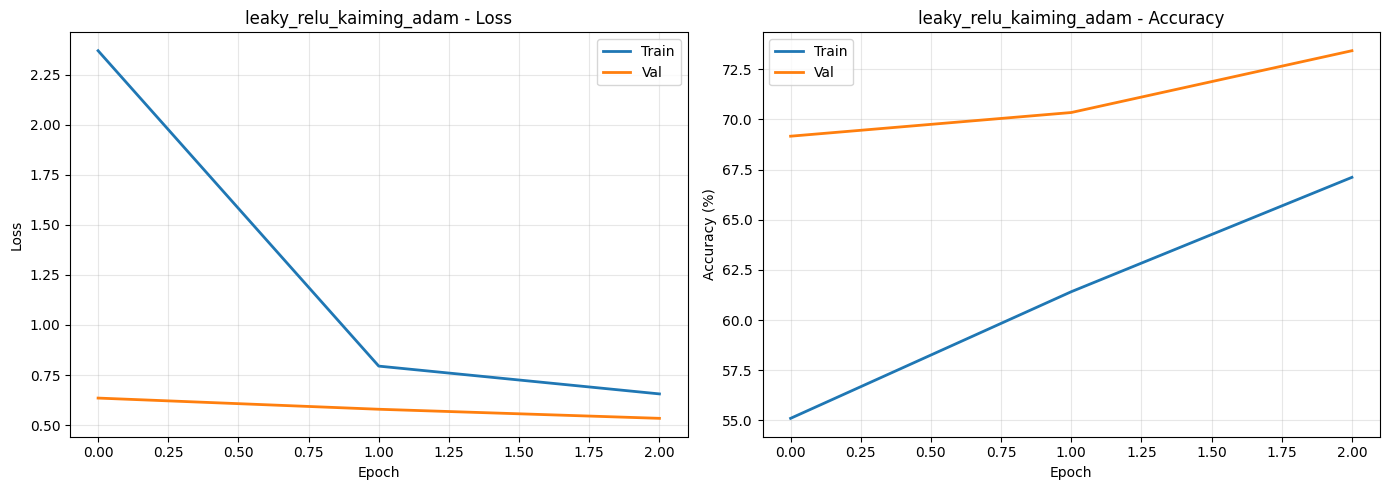

Best Val Acc: 73.42%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 24/27: leaky_relu_kaiming_rmsprop



Epoch 1/3: 100%|██████████| 313/313 [01:14<00:00,  4.19it/s, loss=13.3022, acc=53.10%]


Epoch [1/3]
Train Loss: 13.3022, Train Acc: 53.10%
Val Loss: 0.8643, Val Acc: 61.56%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:14<00:00,  4.18it/s, loss=1.2622, acc=55.76%]


Epoch [2/3]
Train Loss: 1.2622, Train Acc: 55.76%
Val Loss: 0.8491, Val Acc: 64.48%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:14<00:00,  4.22it/s, loss=0.8980, acc=58.47%]


Epoch [3/3]
Train Loss: 0.8980, Train Acc: 58.47%
Val Loss: 0.7586, Val Acc: 54.48%
------------------------------------------------------------


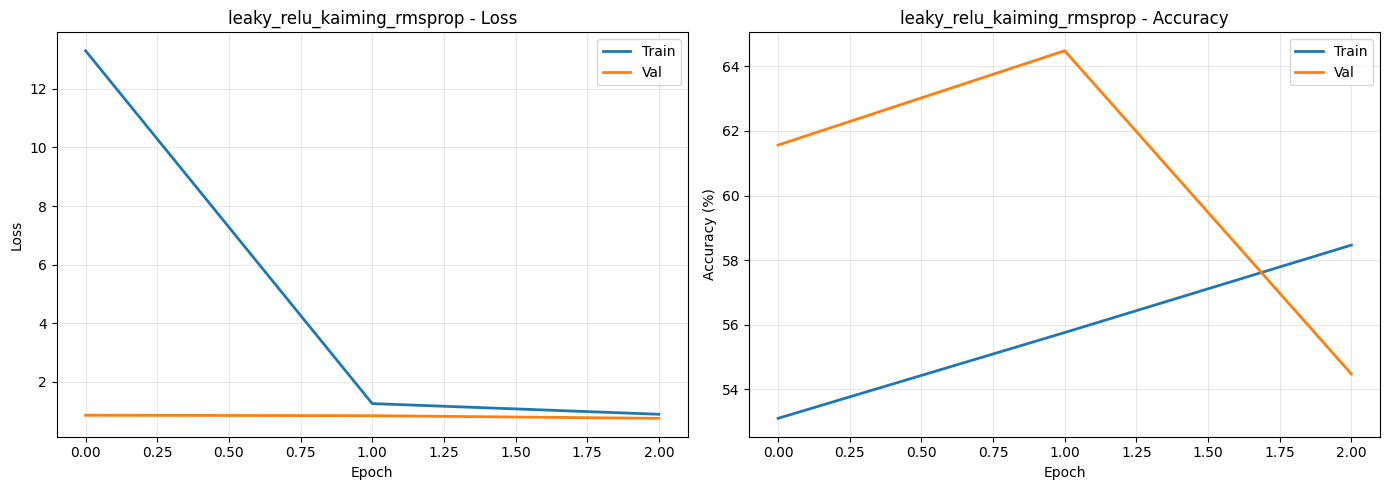

Best Val Acc: 64.48%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 25/27: leaky_relu_random_sgd



Epoch 1/3: 100%|██████████| 313/313 [01:16<00:00,  4.12it/s, loss=2.0689, acc=52.49%]


Epoch [1/3]
Train Loss: 2.0689, Train Acc: 52.49%
Val Loss: 0.6925, Val Acc: 58.14%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:15<00:00,  4.12it/s, loss=0.7375, acc=55.34%]


Epoch [2/3]
Train Loss: 0.7375, Train Acc: 55.34%
Val Loss: 0.6542, Val Acc: 60.44%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:15<00:00,  4.15it/s, loss=0.7065, acc=57.67%]


Epoch [3/3]
Train Loss: 0.7065, Train Acc: 57.67%
Val Loss: 0.6463, Val Acc: 62.82%
------------------------------------------------------------


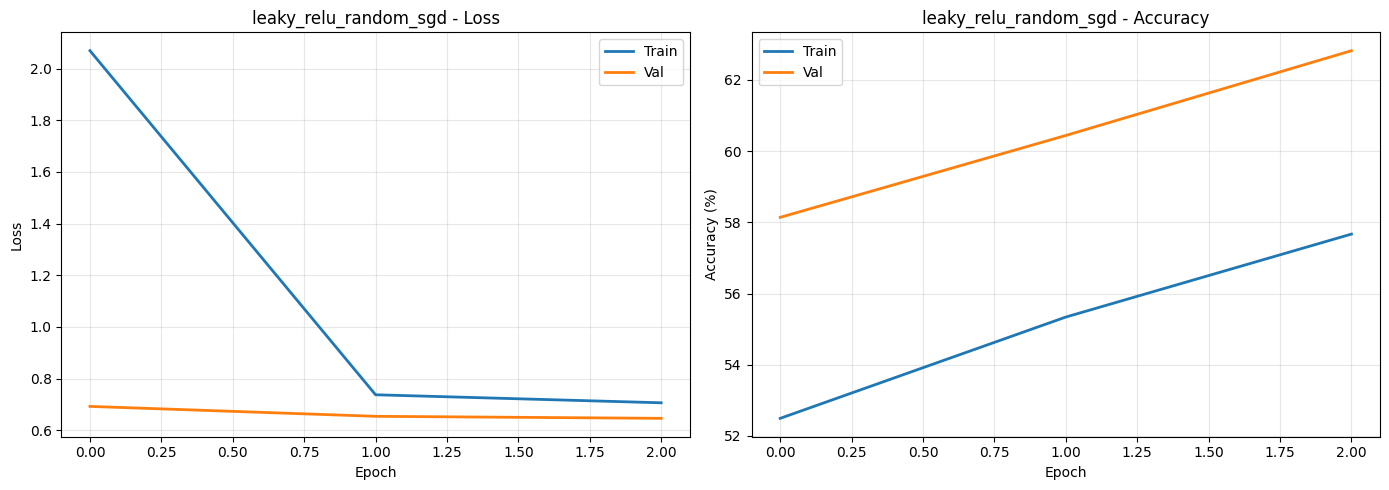

Best Val Acc: 62.82%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 26/27: leaky_relu_random_adam



Epoch 1/3: 100%|██████████| 313/313 [01:14<00:00,  4.22it/s, loss=1.7848, acc=54.78%]


Epoch [1/3]
Train Loss: 1.7848, Train Acc: 54.78%
Val Loss: 0.6097, Val Acc: 66.70%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:14<00:00,  4.17it/s, loss=0.6979, acc=63.52%]


Epoch [2/3]
Train Loss: 0.6979, Train Acc: 63.52%
Val Loss: 0.5662, Val Acc: 70.98%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:16<00:00,  4.11it/s, loss=0.6043, acc=68.06%]


Epoch [3/3]
Train Loss: 0.6043, Train Acc: 68.06%
Val Loss: 0.5567, Val Acc: 71.90%
------------------------------------------------------------


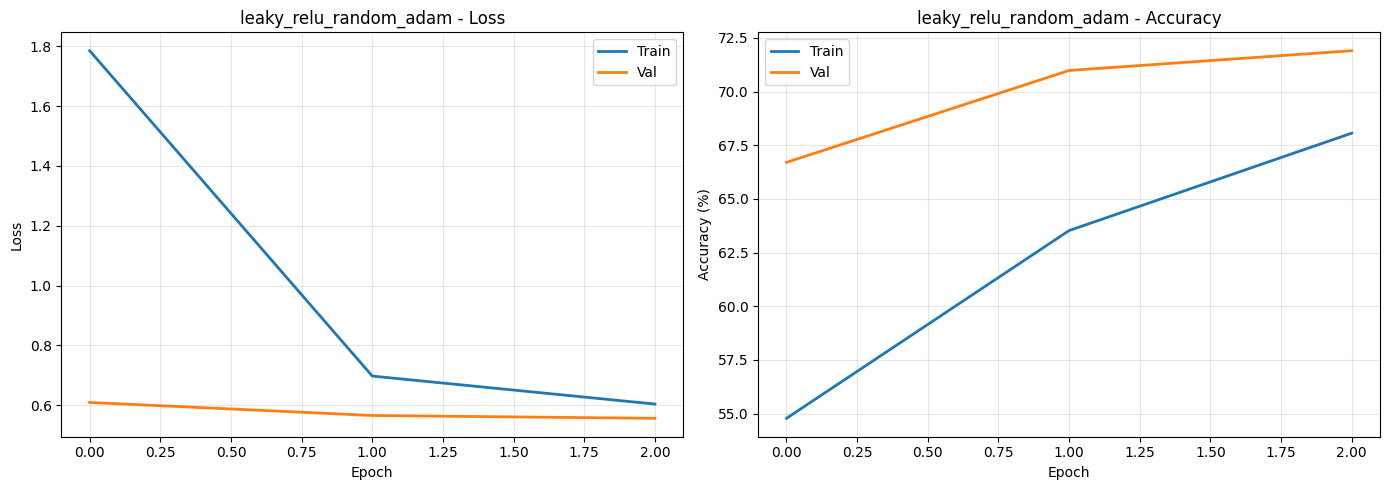

Best Val Acc: 71.90%
Current best overall: relu_xavier_sgd (73.66%)

Experiment 27/27: leaky_relu_random_rmsprop



Epoch 1/3: 100%|██████████| 313/313 [01:15<00:00,  4.15it/s, loss=6.5920, acc=53.48%]


Epoch [1/3]
Train Loss: 6.5920, Train Acc: 53.48%
Val Loss: 0.6474, Val Acc: 61.68%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:15<00:00,  4.14it/s, loss=0.8492, acc=56.22%]


Epoch [2/3]
Train Loss: 0.8492, Train Acc: 56.22%
Val Loss: 0.7800, Val Acc: 58.68%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:15<00:00,  4.17it/s, loss=0.6785, acc=61.40%]


Epoch [3/3]
Train Loss: 0.6785, Train Acc: 61.40%
Val Loss: 0.8962, Val Acc: 54.62%
------------------------------------------------------------


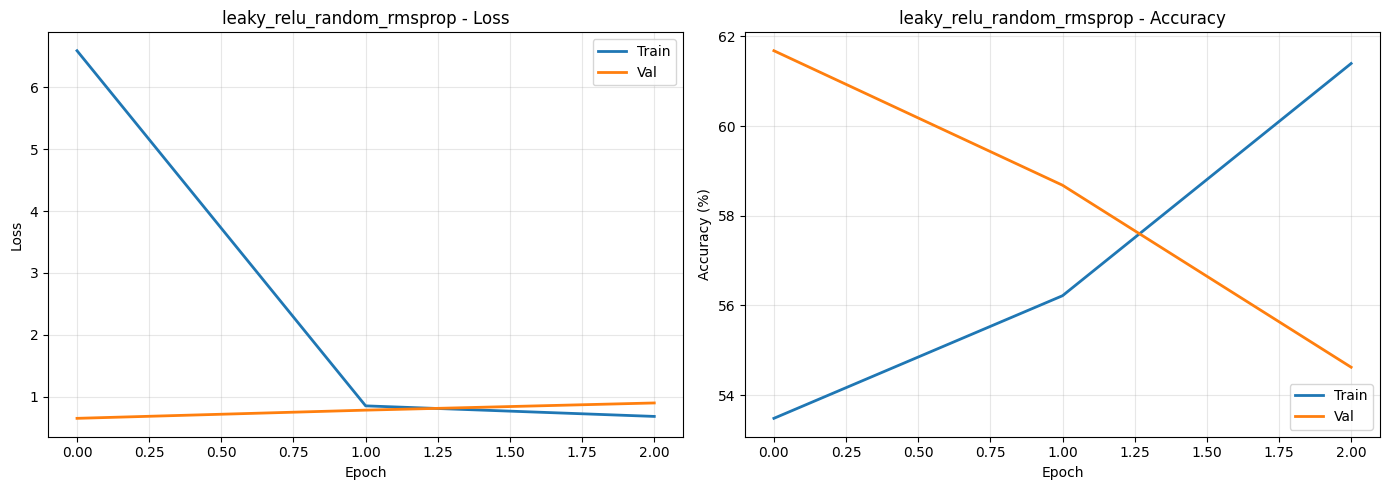

Best Val Acc: 61.68%
Current best overall: relu_xavier_sgd (73.66%)

ALL EXPERIMENTS COMPLETED!
Best Configuration: relu_xavier_sgd
Best Accuracy: 73.66%


In [12]:
activations = ['relu', 'tanh', 'leaky_relu']
initializations = {
    'xavier': init_weights_xavier,
    'kaiming': init_weights_kaiming,
    'random': init_weights_random
}
optimizers_config = ['sgd', 'adam', 'rmsprop']

all_results = {}
best_config = None
best_acc = 0.0

total_experiments = len(activations) * len(initializations) * len(optimizers_config)
experiment_num = 0

print(f"Starting {total_experiments} experiments...")
print("="*80)

for activation in activations:
    for init_name, init_func in initializations.items():
        for opt_name in optimizers_config:
            experiment_num += 1
            config_name = f"{activation}_{init_name}_{opt_name}"

            print(f"\n{'='*80}")
            print(f"Experiment {experiment_num}/{total_experiments}: {config_name}")
            print(f"{'='*80}\n")

            # Create model
            model = CatDogCNN(activation=activation).to(device)
            model.apply(init_func)

            # Optimizer
            if opt_name == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            elif opt_name == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            else:
                optimizer = optim.RMSprop(model.parameters(), lr=0.001)

            criterion = nn.CrossEntropyLoss()

            # Train
            history = train_model(model, train_loader, val_loader, criterion,
                                optimizer, num_epochs=3, device=device,
                                model_name=config_name)

            all_results[config_name] = history

            # Plot
            plot_history(history, config_name,
                        f'/content/results/{config_name}_history.png')

            # Track best
            if history['best_val_acc'] > best_acc:
                best_acc = history['best_val_acc']
                best_config = config_name

            print(f"Best Val Acc: {history['best_val_acc']:.2f}%")
            print(f"Current best overall: {best_config} ({best_acc:.2f}%)")

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED!")
print(f"Best Configuration: {best_config}")
print(f"Best Accuracy: {best_acc:.2f}%")
print("="*80)

## Cell 12: Save Results Summary

In [13]:
results_summary = {
    'best_config': best_config,
    'best_accuracy': best_acc,
    'all_configs': {}
}

for config_name, history in all_results.items():
    results_summary['all_configs'][config_name] = {
        'best_val_acc': history['best_val_acc'],
        'final_train_acc': history['train_accs'][-1],
        'final_val_acc': history['val_accs'][-1],
    }

with open('/content/results/experiment_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print("Results saved!")

Results saved!


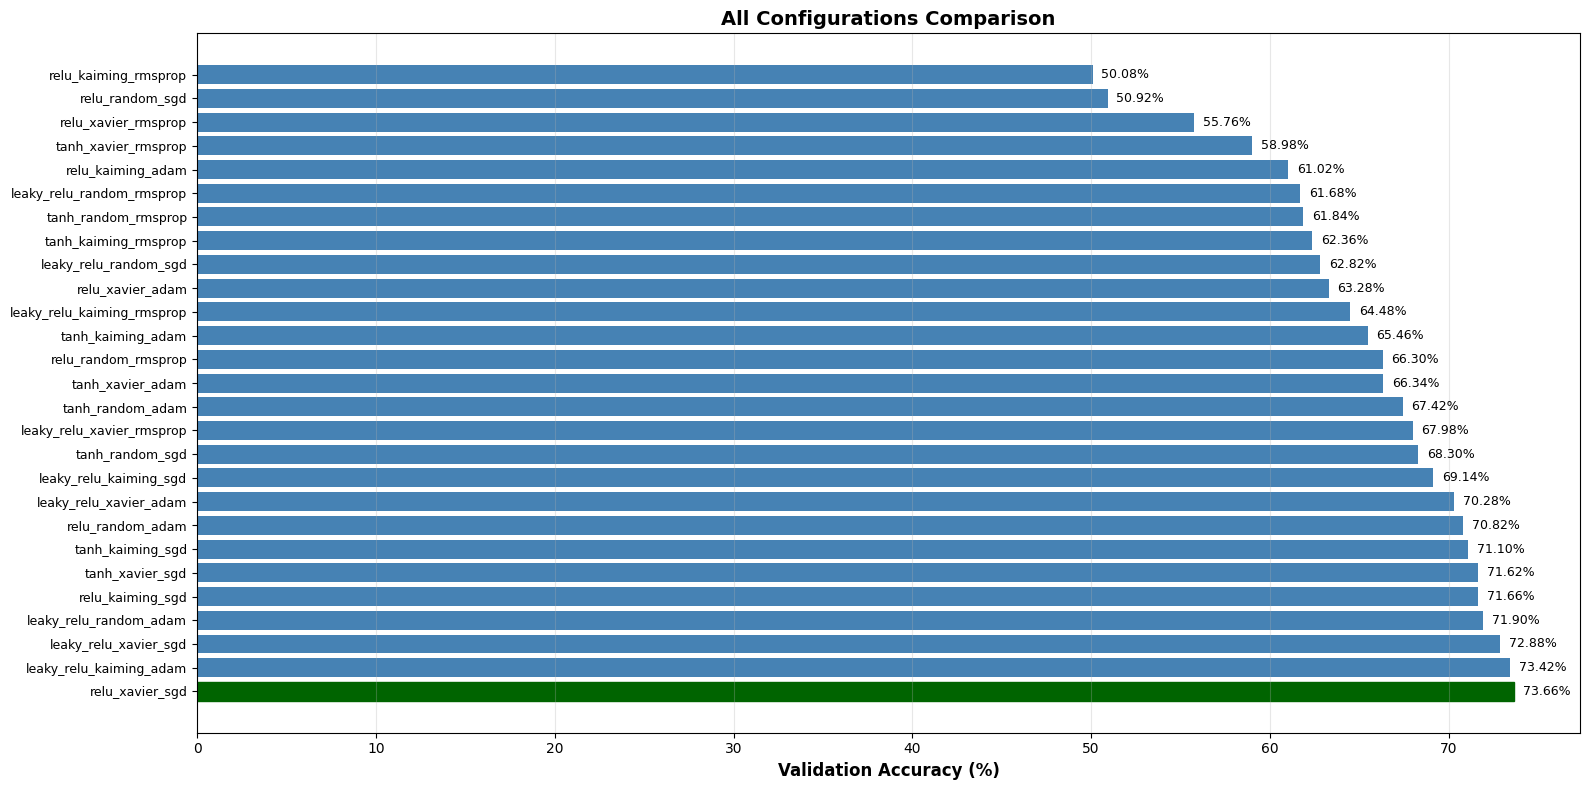

In [14]:
configs = list(all_results.keys())
accuracies = [all_results[c]['best_val_acc'] for c in configs]

sorted_idx = np.argsort(accuracies)[::-1]
configs_sorted = [configs[i] for i in sorted_idx]
accs_sorted = [accuracies[i] for i in sorted_idx]

plt.figure(figsize=(16, 8))
bars = plt.barh(range(len(configs_sorted)), accs_sorted, color='steelblue')
bars[0].set_color('darkgreen')

plt.yticks(range(len(configs_sorted)), configs_sorted, fontsize=9)
plt.xlabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('All Configurations Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(accs_sorted):
    plt.text(v + 0.5, i, f'{v:.2f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('/content/results/all_configs_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

ResNet-18 parameters: 11,177,538
Training ResNet-18...


Epoch 1/3: 100%|██████████| 313/313 [01:10<00:00,  4.47it/s, loss=0.1397, acc=94.22%]


Epoch [1/3]
Train Loss: 0.1397, Train Acc: 94.22%
Val Loss: 0.0679, Val Acc: 97.24%
------------------------------------------------------------


Epoch 2/3: 100%|██████████| 313/313 [01:08<00:00,  4.54it/s, loss=0.0754, acc=97.11%]


Epoch [2/3]
Train Loss: 0.0754, Train Acc: 97.11%
Val Loss: 0.0760, Val Acc: 96.88%
------------------------------------------------------------


Epoch 3/3: 100%|██████████| 313/313 [01:09<00:00,  4.53it/s, loss=0.0556, acc=97.89%]


Epoch [3/3]
Train Loss: 0.0556, Train Acc: 97.89%
Val Loss: 0.0743, Val Acc: 97.00%
------------------------------------------------------------


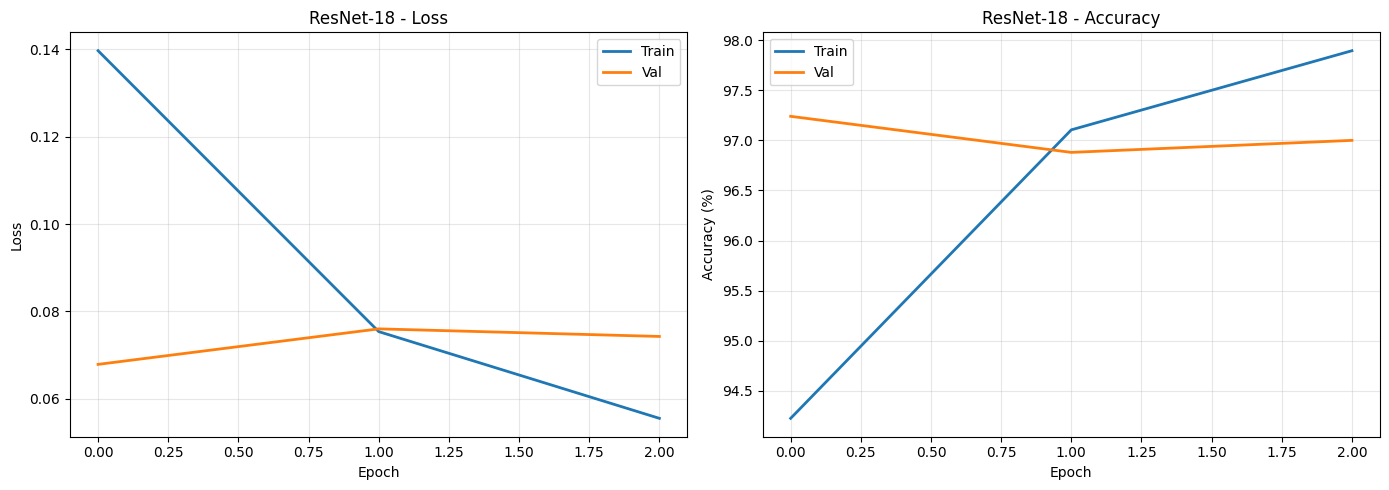

ResNet-18 Best Val Acc: 97.24%


In [16]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)
resnet18 = resnet18.to(device)

print(f"ResNet-18 parameters: {sum(p.numel() for p in resnet18.parameters()):,}")

# Train
resnet_optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)
resnet_criterion = nn.CrossEntropyLoss()

print("Training ResNet-18...")
resnet_history = train_model(resnet18, train_loader, val_loader,
                            resnet_criterion, resnet_optimizer,
                            num_epochs=3, device=device,
                            model_name='resnet18')

plot_history(resnet_history, 'ResNet-18',
            '/content/results/resnet18_history.png')

print(f"ResNet-18 Best Val Acc: {resnet_history['best_val_acc']:.2f}%")

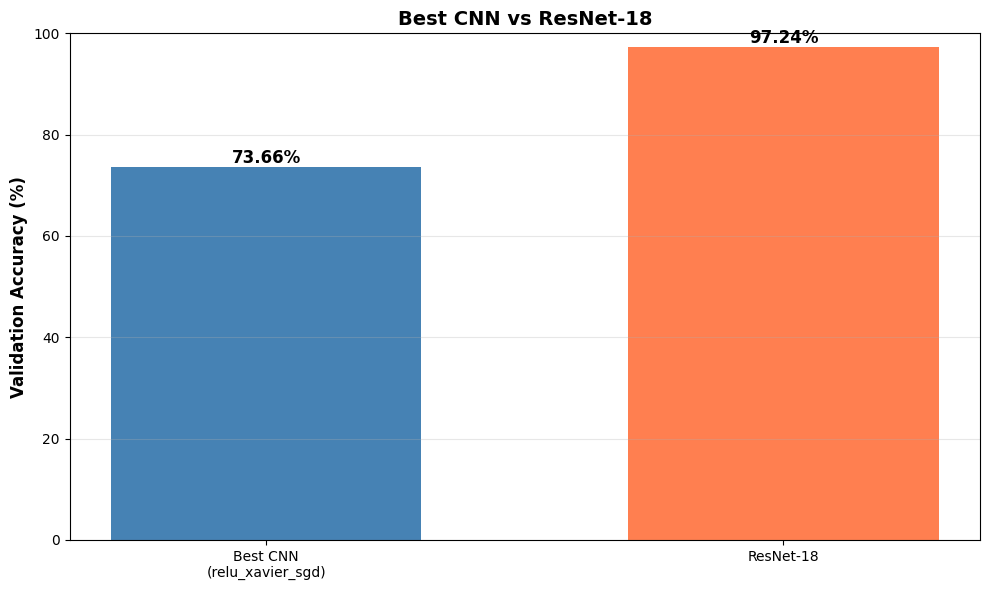


Best CNN: 73.66%
ResNet-18: 97.24%
Difference: 23.58%


In [17]:
comparison = {
    f'Best CNN\n({best_config})': all_results[best_config]['best_val_acc'],
    'ResNet-18': resnet_history['best_val_acc']
}

plt.figure(figsize=(10, 6))
bars = plt.bar(comparison.keys(), comparison.values(),
              color=['steelblue', 'coral'], width=0.6)

plt.ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Best CNN vs ResNet-18', fontsize=14, fontweight='bold')
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom',
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/results/cnn_vs_resnet.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBest CNN: {comparison[f'Best CNN\n({best_config})']:.2f}%")
print(f"ResNet-18: {comparison['ResNet-18']:.2f}%")
print(f"Difference: {abs(comparison['ResNet-18'] - comparison[f'Best CNN\n({best_config})']):.2f}%")

In [18]:
!cp -r /content/models/* /content/drive/MyDrive/DL_Lab/Experiment4/
!cp -r /content/results/* /content/drive/MyDrive/DL_Lab/Experiment4/

print("All results saved to Google Drive!")
print("Location: /content/drive/MyDrive/DL_Lab/Experiment4/")

All results saved to Google Drive!
Location: /content/drive/MyDrive/DL_Lab/Experiment4/


In [19]:
!cd /content && zip -r experiment4_results.zip models/ results/

from google.colab import files
files.download('/content/experiment4_results.zip')

print("\n" + "="*80)
print("EXPERIMENT COMPLETE!")
print("="*80)
print(f"Best Configuration: {best_config}")
print(f"Best CNN Accuracy: {best_acc:.2f}%")
print(f"ResNet-18 Accuracy: {resnet_history['best_val_acc']:.2f}%")
print("="*80)

  adding: models/ (stored 0%)
  adding: models/tanh_xavier_rmsprop_best.pth (deflated 10%)
  adding: models/tanh_xavier_sgd_best.pth (deflated 8%)
  adding: models/tanh_random_rmsprop_best.pth (deflated 11%)
  adding: models/leaky_relu_kaiming_adam_best.pth (deflated 9%)
  adding: models/tanh_kaiming_sgd_best.pth (deflated 8%)
  adding: models/tanh_random_sgd_best.pth (deflated 8%)
  adding: models/relu_random_rmsprop_best.pth (deflated 9%)
  adding: models/resnet18_best.pth (deflated 8%)
  adding: models/tanh_kaiming_rmsprop_best.pth (deflated 10%)
  adding: models/relu_xavier_adam_best.pth (deflated 34%)
  adding: models/relu_kaiming_adam_best.pth (deflated 33%)
  adding: models/relu_xavier_rmsprop_best.pth (deflated 9%)
  adding: models/tanh_kaiming_adam_best.pth (deflated 9%)
  adding: models/relu_random_adam_best.pth (deflated 30%)
  adding: models/relu_kaiming_sgd_best.pth (deflated 43%)
  adding: models/tanh_xavier_adam_best.pth (deflated 9%)
  adding: models/leaky_relu_random_a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


EXPERIMENT COMPLETE!
Best Configuration: relu_xavier_sgd
Best CNN Accuracy: 73.66%
ResNet-18 Accuracy: 97.24%
